# Data Pipeline - Cars Dataset

Dataset of 16,185 car images available at https://ai.stanford.edu/~jkrause/cars/car_dataset.html

Images are not the same size or resolution. This file converts all images in a standard format: 64*64 px

In [10]:
# Modify to run on your local machine

cars_path = "C:\\Users\\Nicolas\\Downloads\\CS282A_Deep_Project\\Cars_train\\"
#test_path = "/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_test/"
train_path = "C:\\Users\\Nicolas\\Downloads\\CS282A_Deep_Project\\Cars_train\\cars_train\\"
#cars_prep_path = "/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/"

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import pickle
import csv
import os
from PIL import Image

%matplotlib inline

## Examples

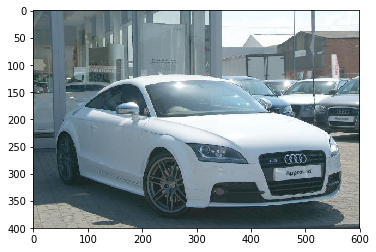

In [3]:
image = Image.open(cars_path + "cars_train/00001.jpg")
plt.imshow(image)

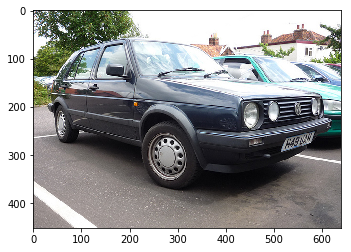

In [4]:
image = Image.open(cars_path + "cars_train/00042.jpg")
plt.imshow(image)

In [5]:
## Number of images in the dataset

print(len(os.listdir(train_path)) + len(os.listdir(test_path)), "images found")

NameError: name 'test_path' is not defined

## Resize Format

In [6]:
height = width = 64 
channels = 3 #RGB

## Load dataset

#### Open images as Numpy array

In [11]:
#test_images = os.listdir(test_path)
train_images = os.listdir(train_path)

X_train = np.zeros((len(train_images), height, width, channels))
#X_test = np.zeros((len(test_images), height, width, channels))

# print("Loading Test Set...")
# for i in range(len(test_images)):
#     img = Image.open(test_path + test_images[i])
#     try:
#         X_test[i] = np.asarray(img.resize((height, width)))
#     except:
#         # gray scale images cannot be loaded as RGB
#         print(test_images[i], "Could not be loaded")
#         X_test[i] = X_test[i-1] #just to not have a null image
# print(" ")
        
print("Loading Train Set...")
for i in range(len(train_images)):
    img = Image.open(train_path + train_images[i])
    try:
        X_train[i] = np.asarray(img.resize((height, width)))
    except:
        # gray scale images cannot be loaded as RGB
        print(train_images[i], "Could not be loaded")
        X_train[i] = X_train[i-1] #just to not have a null image

Loading Train Set...
00266.jpg Could not be loaded
01085.jpg Could not be loaded
02176.jpg Could not be loaded
03048.jpg Could not be loaded
03439.jpg Could not be loaded
03469.jpg Could not be loaded
03539.jpg Could not be loaded
04577.jpg Could not be loaded
04848.jpg Could not be loaded
05177.jpg Could not be loaded
05502.jpg Could not be loaded
05713.jpg Could not be loaded
06947.jpg Could not be loaded
07383.jpg Could not be loaded
07693.jpg Could not be loaded
07774.jpg Could not be loaded
08137.jpg Could not be loaded
08144.jpg Could not be loaded


In [12]:
# Sanity check
print("X_train shape:", X_train.shape)
#print("X_test shape:", X_test.shape)

X_train shape: (8144, 64, 64, 3)


#### Concat train and test set (we will define our own train and test set later)

In [13]:
X_all = np.vstack([X_train])#
print("X_all shape:", X_all.shape)

X_all shape: (8144, 64, 64, 3)


#### Reshape to standard format (N, C, H, W) for deep learning models

In [14]:
def reshape_NCHW(X):
    return X.transpose((0, 3, 1, 2))

X_all = reshape_NCHW(X_all)
print("X_all shape:", X_all.shape)

X_all shape: (8144, 3, 64, 64)


#### Standardize images

Set all pixel values between 0 and 1, by dividing by 255 (range of RGB pixel)

In [15]:
def standardize(X):
    return X / 255.

X_all = standardize(X_all)

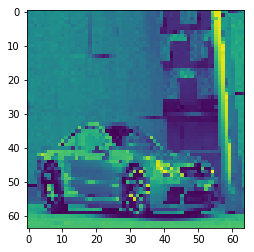

In [18]:
# example
plt.imshow(X_all[8141, 0, :, :])

#### Image mask/default generator

Assumption: we impose a mask to be a least 7 in width and 7 in height (except if mask touches the borders)

In [19]:
# save an original X_all dataset
X_original = X_all.copy()

In [20]:
def mask(img, loc):
    """Set to zero all pixels contained in a given location on the image
    
    Input:
    - img: image of shape (C, H, W)
    - loc: location (x, y, h, w)
    """
    x, y, h, w = loc
    h = min(h, height-y)
    w = min(w, width-x)
    img[:, x:x+w, y:y+h] = 0.5

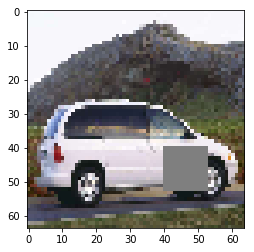

In [21]:
# example 
mask(X_all[13], (40, 40, 13, 13))
plt.imshow(X_all[13].transpose(1, 2, 0))

#### genrate a full dataset of images with random masks

In [22]:
range_x = np.arange(width)
range_y = np.arange(height)
range_h = np.arange(10, 20)
range_w = np.arange(10, 20)

In [23]:
np.random.seed(123)

# Uniform
xs = np.random.choice(range_x, X_all.shape[0]) # upper left corner
ys = np.random.choice(range_y, X_all.shape[0]) # upper left corner
hs = np.random.choice(range_h, X_all.shape[0]) # height
ws = np.random.choice(range_w, X_all.shape[0]) # width

# Gaussian
xg = np.random.normal(25,10,X_all.shape[0]) 
yg = np.random.normal(25,10,X_all.shape[0])

gaussian = True

if gaussian:
    for img, x, y, h, w in zip(X_all, xg.astype(int), yg.astype(int), hs, ws):
        mask(img, (x, y, h, w))
else:
    for img, x, y, h, w in zip(X_all, xs, ys, hs, ws):
        mask(img, (x, y, h, w))

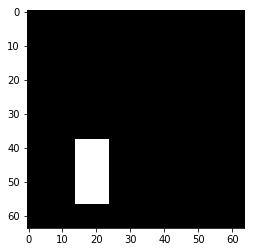

In [24]:
filter_mask = np.zeros(X_train.shape)

for i, x, y, h, w in zip(range(filter_mask.shape[0]), xg.astype(int), yg.astype(int), hs, ws):
    filter_mask[i, x:x+w, y:y+h, :] = 1.
plt.imshow(filter_mask[49])

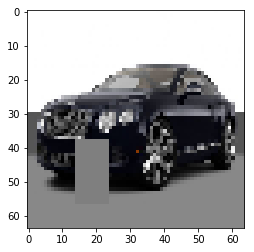

In [25]:
# sanity check
plt.imshow(X_all[49].transpose(1, 2, 0))

In [26]:
# Save modified dataset (with masks) as pickle file in cars_prep_path directory
with open(cars_prep_path + "cars_masks.pickle", "wb") as file:
    pickle.dump(X_all, file)

NameError: name 'cars_prep_path' is not defined

In [100]:
# Save original dataset (without masks) as pickle file in cars_prep_path directory
with open(cars_prep_path + "cars_original.pickle", "wb") as file:
    pickle.dump(X_original, file)

In [101]:
# Save mask filters as pickle file in cars_prep_path directory
with open(cars_prep_path + "cars_filter.pickle", "wb") as file:
    pickle.dump(filter_mask, file)

### X_all VS X_original

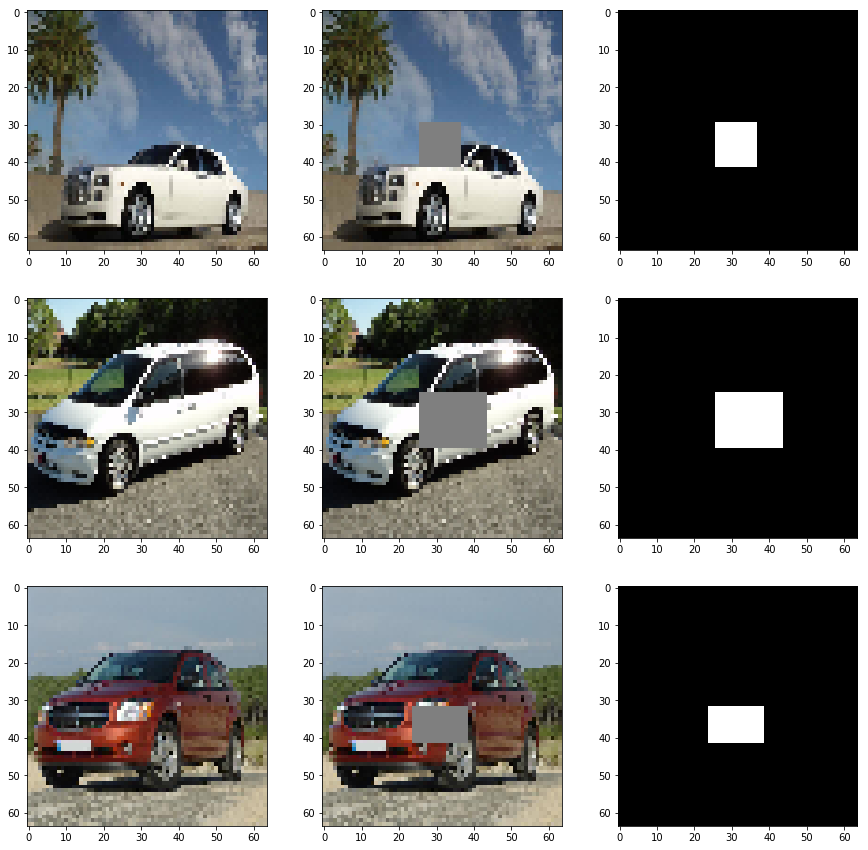

In [27]:
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 1)
plt.imshow(X_original[117].transpose(1, 2, 0))
plt.subplot(3, 3, 2)
plt.imshow(X_all[117].transpose(1, 2, 0))
plt.subplot(3, 3, 3)
plt.imshow(filter_mask[117])
plt.subplot(3, 3, 4)
plt.imshow(X_original[2222].transpose(1, 2, 0))
plt.subplot(3, 3, 5)
plt.imshow(X_all[2222].transpose(1, 2, 0))
plt.subplot(3, 3, 6)
plt.imshow(filter_mask[2222])
plt.subplot(3, 3, 7)
plt.imshow(X_original[231].transpose(1, 2, 0))
plt.subplot(3, 3, 8)
plt.imshow(X_all[231].transpose(1, 2, 0))
plt.subplot(3, 3, 9)
plt.imshow(filter_mask[231])

**SSIM Baseline on the training set**

In [61]:
from skimage import measure

In [62]:
from skimage import data, img_as_float

In [63]:
s = []
psnr=[]

In [64]:
for i in range(len(X_original)):
    s.append(measure.compare_ssim(X_original[i].transpose(1, 2, 0), X_all[i].transpose(1, 2, 0), multichannel=True))
    #psnr.append(measure.compare_psnr(X_original[i], X_all[i]))

In [65]:
s_mean=np.mean(s)
#psnr_mean=np.mean(psnr)

In [66]:
s_mean

0.9406234388791969

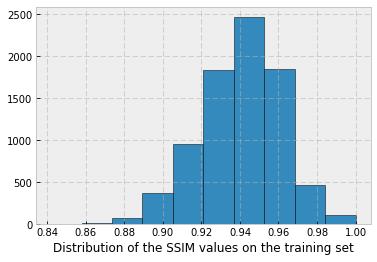

In [67]:
with plt.style.context('bmh'):
    plt.hist(s,ec='black')
    plt.xlabel('Distribution of the SSIM values on the training set')